In [1]:
import pandas as pd 
import random 
import os
import numpy as np 
import tensorflow as tf 
from sklearn import ensemble
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import gc
from keras.callbacks import ModelCheckpoint

In [2]:
file_path='hopefully_model.hope'
check_point=ModelCheckpoint(file_path,monitor='loss',verbose=1,save_best_only=True,mode='min')
callbacks=[check_point]

In [3]:
import pickle
with open("../input/segmented-data-1/ct_data.pkl",'rb')as f:
    data_ct=pickle.load(f)

In [4]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
tr['min_week'] = tr['Weeks']
tr['min_week'] = tr.groupby('Patient')['min_week'].transform('min')
base = tr.loc[tr.Weeks == tr.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)
tr = tr.merge(base, on='Patient', how='left')
tr['base_week'] = tr['Weeks'] - tr['min_week']
del base
gc.collect()
COLS = ['Sex','SmokingStatus'] #,'Age'

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
gender=LabelBinarizer().fit(tr[['Sex']])
tr['gender']=gender.transform(tr[['Sex']])
smkstat=LabelBinarizer()
ww=smkstat.fit_transform(tr.SmokingStatus)
df_smk=pd.DataFrame(ww,columns=smkstat.classes_)
tr=tr.merge(df_smk,how='left',left_index=True,right_index=True)
gc.collect()

20

In [6]:
def set_percentage(tr):
    df=tr.copy()
    pateints=df.loc[:,'Patient'].astype(str).unique()
    for n, pat in enumerate(pateints):
        percent=df.loc[(df.Patient.astype(str)==pat)&(df.base_week==0),"Percent"].values[0]
        df.loc[df.Patient.astype(str)==pat,'Percent']=percent
        print(n)
    return df

In [7]:
tr=set_percentage(tr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175


In [8]:
cols=["Weeks","FVC","Percent","Age","min_week","min_FVC","base_week"]
cols_norm=MinMaxScaler()
norm=cols_norm.fit_transform(tr[cols])
norm_df=pd.DataFrame(norm,columns=[new_name+'_norm' for new_name in cols ])
gc.collect()

20

In [9]:
tr=tr.merge(norm_df,how='right',left_index=True,right_index=True)

In [10]:
tr

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,min_FVC,base_week,...,Currently smokes,Ex-smoker,Never smoked,Weeks_norm,FVC_norm,Percent_norm,Age_norm,min_week_norm,min_FVC_norm,base_week_norm
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,2315,0,...,0,1,0,0.007246,0.267050,0.135886,0.769231,0.011905,0.241456,0.000000
1,ID00007637202177411956430,5,2214,58.253649,79,Male,Ex-smoker,-4,2315,9,...,0,1,0,0.072464,0.248923,0.135886,0.769231,0.011905,0.241456,0.142857
2,ID00007637202177411956430,7,2061,58.253649,79,Male,Ex-smoker,-4,2315,11,...,0,1,0,0.086957,0.221464,0.135886,0.769231,0.011905,0.241456,0.174603
3,ID00007637202177411956430,9,2144,58.253649,79,Male,Ex-smoker,-4,2315,13,...,0,1,0,0.101449,0.236360,0.135886,0.769231,0.011905,0.241456,0.206349
4,ID00007637202177411956430,11,2069,58.253649,79,Male,Ex-smoker,-4,2315,15,...,0,1,0,0.115942,0.222900,0.135886,0.769231,0.011905,0.241456,0.238095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,ID00426637202313170790466,13,2712,71.824968,73,Male,Never smoked,0,2925,13,...,0,0,1,0.130435,0.338299,0.259644,0.615385,0.059524,0.354755,0.206349
1531,ID00426637202313170790466,19,2978,71.824968,73,Male,Never smoked,0,2925,19,...,0,0,1,0.173913,0.386037,0.259644,0.615385,0.059524,0.354755,0.301587
1532,ID00426637202313170790466,31,2908,71.824968,73,Male,Never smoked,0,2925,31,...,0,0,1,0.260870,0.373475,0.259644,0.615385,0.059524,0.354755,0.492063
1533,ID00426637202313170790466,43,2975,71.824968,73,Male,Never smoked,0,2925,43,...,0,0,1,0.347826,0.385499,0.259644,0.615385,0.059524,0.354755,0.682540


In [11]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = -(delta / sigma_clip)*sq2 -tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

In [12]:
from sklearn.utils import shuffle
def get_patient_ct(data_ct,pateint_id):
    for n,dic in enumerate(data_ct):
        if dic['ID']==pateint_id:
            return n
    return None
def MiniBatch(CTs,tabular,BatchN=0,n=64):
    ct=[]
    ind=[]
    tab=tabular[BatchN*n:BatchN*n+n]
    tab=tab.reset_index()
    for i in range(n):
        ind=get_patient_ct(CTs,tab["Patient"].iloc[i])
        ct.append(CTs[ind]["cts"])
    ct=np.array(ct)
    gc.collect()
    return ct,tab
def training(CTs,Tabular,epochs=10,batch_size=32):
    FE=["Percent_norm","Age_norm","min_FVC_norm","base_week_norm",'gender','Currently smokes','Ex-smoker','Never smoked']
    TabularLentgh=len(Tabular)
    Tabular=shuffle(Tabular)
    Tabular=Tabular.reset_index(drop=True)
    Number_of_Batchs=int(TabularLentgh/batch_size)
    for x in range (epochs):
        print("epoch : ", x)
        for i in range(Number_of_Batchs):
            print(f"batch {i} outta {Number_of_Batchs}")
            cts , tabular = MiniBatch(CTs,Tabular,i,batch_size)
            Y=tabular.FVC
            X=tabular[FE]
            X=X.values
            X=tf.constant(X, dtype=tf.float64)
            Y=tf.constant(Y.values, dtype=tf.float64)
            cts=cts.reshape(batch_size,32,256,256,1)
            model.fit(x=[X,cts],y=Y,batch_size=4,callbacks=callbacks)
        if(TabularLentgh%batch_size != 0  ):
            print("last batch")
            cts , tabular = MiniBatch(CTs,Tabular,Number_of_Batchs,TabularLentgh-batch_size*Number_of_Batchs)
            Y=tabular.FVC
            X=tabular[FE]
            X=X.values
            X=tf.constant(X, dtype=tf.float64)
            Y=tf.constant(Y.values, dtype=tf.float64)
            cts=cts.reshape(TabularLentgh-batch_size*Number_of_Batchs,32,256,256,1)
            model.fit(x=[X,cts],y=Y,batch_size=1,callbacks=callbacks)

In [13]:
def norm_cts(cts):
    norm_cts=(cts+2740)/(2740)
    return norm_cts
def norm_all_cts():
    for n,data in enumerate(data_ct):
        temp_cts=norm_cts(data["cts"])
        data['cts']=temp_cts
        print(n)
norm_all_cts()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175


In [14]:
from keras.layers import *
from keras.models import Model
from keras.layers.merge import concatenate,Add
import tensorflow as tf


left_input = Input(shape=(8, ), name='left_input')
left_branch = Dense(16, input_dim=8, name='left_branch')(left_input)
left_branch= L.Dense(25, activation="relu", name="d2")(left_branch)
left_branch= L.Dense(100, activation="relu", name="d3")(left_branch)


right_input = Input(shape=(32,256,256,1), name='right_input')
right_branch = Conv3D(16, (2,2,2), activation='relu',padding='same' , input_shape=(32,256,256), name='right_branch')(right_input)
right_branch = MaxPooling3D((2,2,2),padding='same' , name='right_branch2')(right_branch)
right_branch=Dropout(0.2,name="drop1")(right_branch)
right_branch = Conv3D(16, (2,2,2), activation='relu',padding='same' , name='right_branch3')(right_branch)
right_branch=BatchNormalization()(right_branch)
right_branch = MaxPooling3D((2,2,2),padding='same' , name='right_branch4')(right_branch)
right_branch = Conv3D(32, (2,2,2), activation='relu',padding='same' , name='right_branch5')(right_branch)
right_branch = MaxPooling3D((2,2,2),padding='same' , name='right_branch6')(right_branch)
right_branch = Conv3D(64, (2,2,2), activation='relu',padding='same' , name='right_branch7')(right_branch)
right_branch=Dropout(0.36,name="drop2")(right_branch)
right_branch=BatchNormalization()(right_branch)
right_branch = MaxPooling3D((2,2,2),padding='same' , name='right_branch8')(right_branch)
right_branch = Conv3D(128, (2,2,2), activation='relu',padding='same' , name='right_branch9')(right_branch)
right_branch=Dropout(0.36,name="drop3")(right_branch)
right_branch = Flatten()(right_branch)
right_branch=Dense(50)(right_branch)
x = concatenate([left_branch, right_branch])
a=Dense(100,activation="relu")(x)
a=Dense(10, activation='relu', name='main_')(a)
p1 = L.Dense(3, activation="linear", name="p1")(a)
p2 = L.Dense(3, activation="relu", name="p2")(a)
preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                 name="preds")([p1, p2])

model = Model(inputs=[left_input, right_input], outputs=preds)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False),loss=mloss(0.8),metrics=[score])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
right_input (InputLayer)        [(None, 32, 256, 256 0                                            
__________________________________________________________________________________________________
right_branch (Conv3D)           (None, 32, 256, 256, 144         right_input[0][0]                
__________________________________________________________________________________________________
right_branch2 (MaxPooling3D)    (None, 16, 128, 128, 0           right_branch[0][0]               
__________________________________________________________________________________________________
drop1 (Dropout)                 (None, 16, 128, 128, 0           right_branch2[0][0]              
_______________________________________________________________________________________

In [15]:
training(data_ct,tr,batch_size=64,epochs=20)

epoch :  0
batch 0 outta 23
16/16 [==============================] - ETA: 0s - loss: 553.3504 - score: -9.5625
Epoch 00001: loss improved from inf to 553.35040, saving model to hopefully_model.hope
16/16 [==============================] - 6s 377ms/step - loss: 553.3504 - score: -9.5625
batch 1 outta 23
16/16 [==============================] - ETA: 0s - loss: 271.8628 - score: -8.2329
Epoch 00001: loss improved from 553.35040 to 271.86282, saving model to hopefully_model.hope
16/16 [==============================] - 6s 405ms/step - loss: 271.8628 - score: -8.2329
batch 2 outta 23
16/16 [==============================] - ETA: 0s - loss: 232.1063 - score: -8.2647
Epoch 00001: loss improved from 271.86282 to 232.10628, saving model to hopefully_model.hope
16/16 [==============================] - 6s 364ms/step - loss: 232.1063 - score: -8.2647
batch 3 outta 23
16/16 [==============================] - ETA: 0s - loss: 273.8722 - score: -8.2342
Epoch 00001: loss did not improve from 232.10628


In [16]:
model.save("/kaggle/working/after_all_epochs.h5")

In [17]:
with open("/kaggle/working/gender_smkstat_cols_norm.var","wb") as f:
    pickle.dump([gender,smkstat,cols_norm],f)

In [18]:
FE=["Percent_norm","Age_norm","min_FVC_norm","base_week_norm",'gender','Currently smokes','Ex-smoker','Never smoked']
def test(CTs,Tabular,batch_size=1):
    TabularLentgh=len(Tabular)
    Number_of_Batchs=int(TabularLentgh/batch_size)
    for i in range(Number_of_Batchs):
        cts , tabular = MiniBatch(CTs,Tabular,i,batch_size)
        Y=tabular.FVC
        X=tabular[FE]
        X=X.values
        X=tf.constant(X, dtype=tf.float64)
        Y=tf.constant(Y.values, dtype=tf.float64)
        cts=cts.reshape(batch_size,32,256,256,1)
        preds=model.predict(x=[X,cts],batch_size=1)
        if i==0:
            fullpred=preds
        else:
            fullpred=np.concatenate((fullpred,preds))
    if(TabularLentgh%batch_size != 0  ):
        cts , tabular = MiniBatch(CTs,Tabular,Number_of_Batchs,TabularLentgh-batch_size*Number_of_Batchs)
        Y=tabular.FVC
        X=tabular[FE]
        X=X.values
        X=tf.constant(X, dtype=tf.float64)
        Y=tf.constant(Y.values, dtype=tf.float64)
        cts=cts.reshape(TabularLentgh-batch_size*Number_of_Batchs,32,256,256,1)
        preds=model.predict(x=[X,cts],batch_size=1)
        fullpred=np.concatenate((fullpred,preds))

            
    return fullpred

16228.33948366246 7878.596


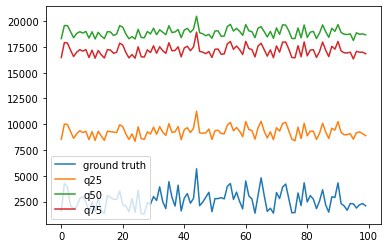

In [19]:
import matplotlib.pyplot as plt
from keras.models import load_model
pred=test(data_ct,tr)
model=load_model("./hopefully_model.hope",custom_objects={ 'loss':mloss(0.8),'score':[score] })
pred2=test(data_ct,tr)
pred=(pred+pred2)/2
y=tr.FVC.values
from sklearn.metrics import mean_absolute_error
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)


idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [20]:
with open("/kaggle/working/sigma_opt_unc_sigma_mean","wb") as f:
    pickle.dump([sigma_opt,unc,sigma_mean],f)

In [21]:
pred

array([[ 8943.199, 18623.967, 16833.719],
       [ 8924.906, 18608.805, 16816.238],
       [ 8920.842, 18605.434, 16812.354],
       ...,
       [ 9433.291, 19108.154, 17343.42 ],
       [ 9408.9  , 19087.938, 17320.111],
       [ 9376.381, 19060.98 , 17289.035]], dtype=float32)